In [180]:
#Делаю подключение с Диском Google 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [181]:
#Пути для файлов
nb_path = '/content/drive/MyDrive/Colab Notebooks/'
data_path = '/content/drive/MyDrive/Colab Notebooks/data/'
models_path = '/content/drive/MyDrive/Colab Notebooks/models/'

In [182]:
#Произвожу импорт всех нужных билиотек для работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn import metrics
import pickle
import tensorflow as tf
from tensorflow import keras

In [183]:
# RANDOM_STATE для повторения результатов
RANDOM_STATE = 3000

In [184]:
# Загрузка данных из X_bp файла
X_bp = pd.read_excel(data_path + 'X_bp.xlsx', index_col=0)
X_bp.shape

(1023, 10)

Файл содержит 1023 строки и 10 признаков

In [185]:
# Загрузка данных из X_nup файла
X_nup = pd.read_excel(data_path + 'X_nup.xlsx', index_col=0)
X_nup.shape

(1040, 3)

Файл содержит 1040 строк и 3 признака

Признаки:

In [186]:
pd.DataFrame(X_bp.columns, columns=['X_bp признаки'])

,X_bp признаки
0,Соотношение матрица-наполнитель
1,"Плотность, кг/м3"
2,"модуль упругости, ГПа"
3,"Количество отвердителя, м.%"
4,"Содержание эпоксидных групп,%_2"
5,"Температура вспышки, С_2"
6,"Поверхностная плотность, г/м2"
7,"Модуль упругости при растяжении, ГПа"
8,"Прочность при растяжении, МПа"
9,"Потребление смолы, г/м2"


In [187]:
pd.DataFrame(X_nup.columns, columns=['X_nup признаки'])

,X_nup признаки
0,"Угол нашивки, град"
1,Шаг нашивки
2,Плотность нашивки


Объединяем датасеты

In [188]:
# Объединяем с INNER как требуется в задании
df = X_bp.join(X_nup, how='inner')
df.shape

(1023, 13)

In [189]:
# Сохраняю данные
df.to_excel(data_path + 'full_dataset.xlsx')

In [190]:
# Просмотрим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг нашивки

Видим, что все признаки имеют тип float64

In [191]:
# Проверка на пропуски
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

По всем признакам видим значение 0, пропусков нет

In [192]:
# Смотрим описательную статистику
df_descr = df.describe().T
df_descr['median'] = df.median()
df_descr.style.format(precision=4)

,count,mean,std,min,25%,50%,75%,max,median
Соотношение матрица-наполнитель,1023.0000,2.9304,0.9132,0.3894,2.3179,2.9069,3.5527,5.5917,2.9069
"Плотность, кг/м3",1023.0000,1975.7349,73.7292,1731.7646,1924.1555,1977.6217,2021.3744,2207.7735,1977.6217
"модуль упругости, ГПа",1023.0000,739.9232,330.2316,2.4369,500.0475,739.6643,961.8125,1911.5365,739.6643
"Количество отвердителя, м.%",1023.0000,110.5708,28.2959,17.7403,92.4435,110.5648,129.7304,198.9532,110.5648
"Содержание эпоксидных групп,%_2",1023.0000,22.2444,2.4063,14.2550,20.6080,22.2307,23.9619,33.0000,22.2307
"Температура вспышки, С_2",1023.0000,285.8822,40.9433,100.0000,259.0665,285.8968,313.0021,413.2734,285.8968
"Поверхностная плотность, г/м2",1023.0000,482.7318,281.3147,0.6037,266.8166,451.8644,693.2250,1399.5424,451.8644
"Модуль упругости при растяжении, ГПа",1023.0000,73.3286,3.1190,64.0541,71.2450,73.2688,75.3566,82.6821,73.2688
"Прочность при растяжении, МПа",1023.0000,2466.9228,485.6280,1036.8566,2135.8504,2459.5245,2767.1931,3848.4367,2459.5245
"Потребление смолы, г/м2",1023.0000,218.4231,59.7359,33.8030,179.6275,219.1989,257.4817,414.5906,219.1989


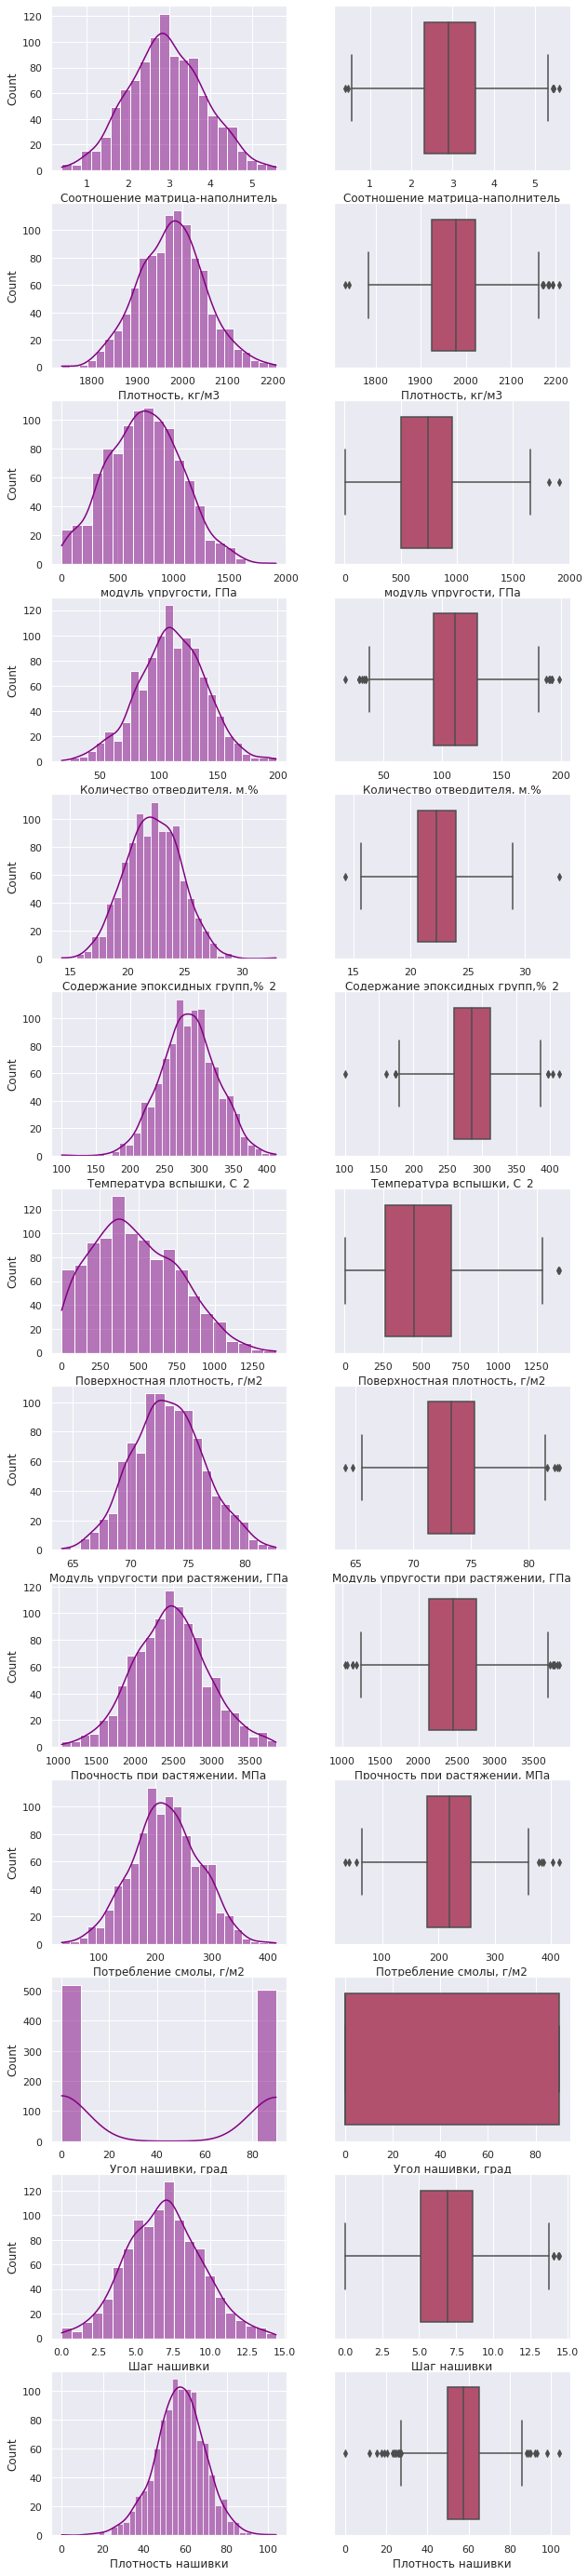

In [193]:
# Смотрим графики распределения и боксплоты - ящики с "усами"
fig, axes = plt.subplots(13, 2, figsize=(10, 50))
for k, column in enumerate(df.columns):    
    sns.histplot(data=df, x=column, kde=True, ax=axes[k, 0], color='purple')
    sns.boxplot(data=df, x=column, ax=axes[k, 1], palette='flare')
plt.show()

Здесь видим, что в целом все данные распределены нормально, кроме угла нашивки

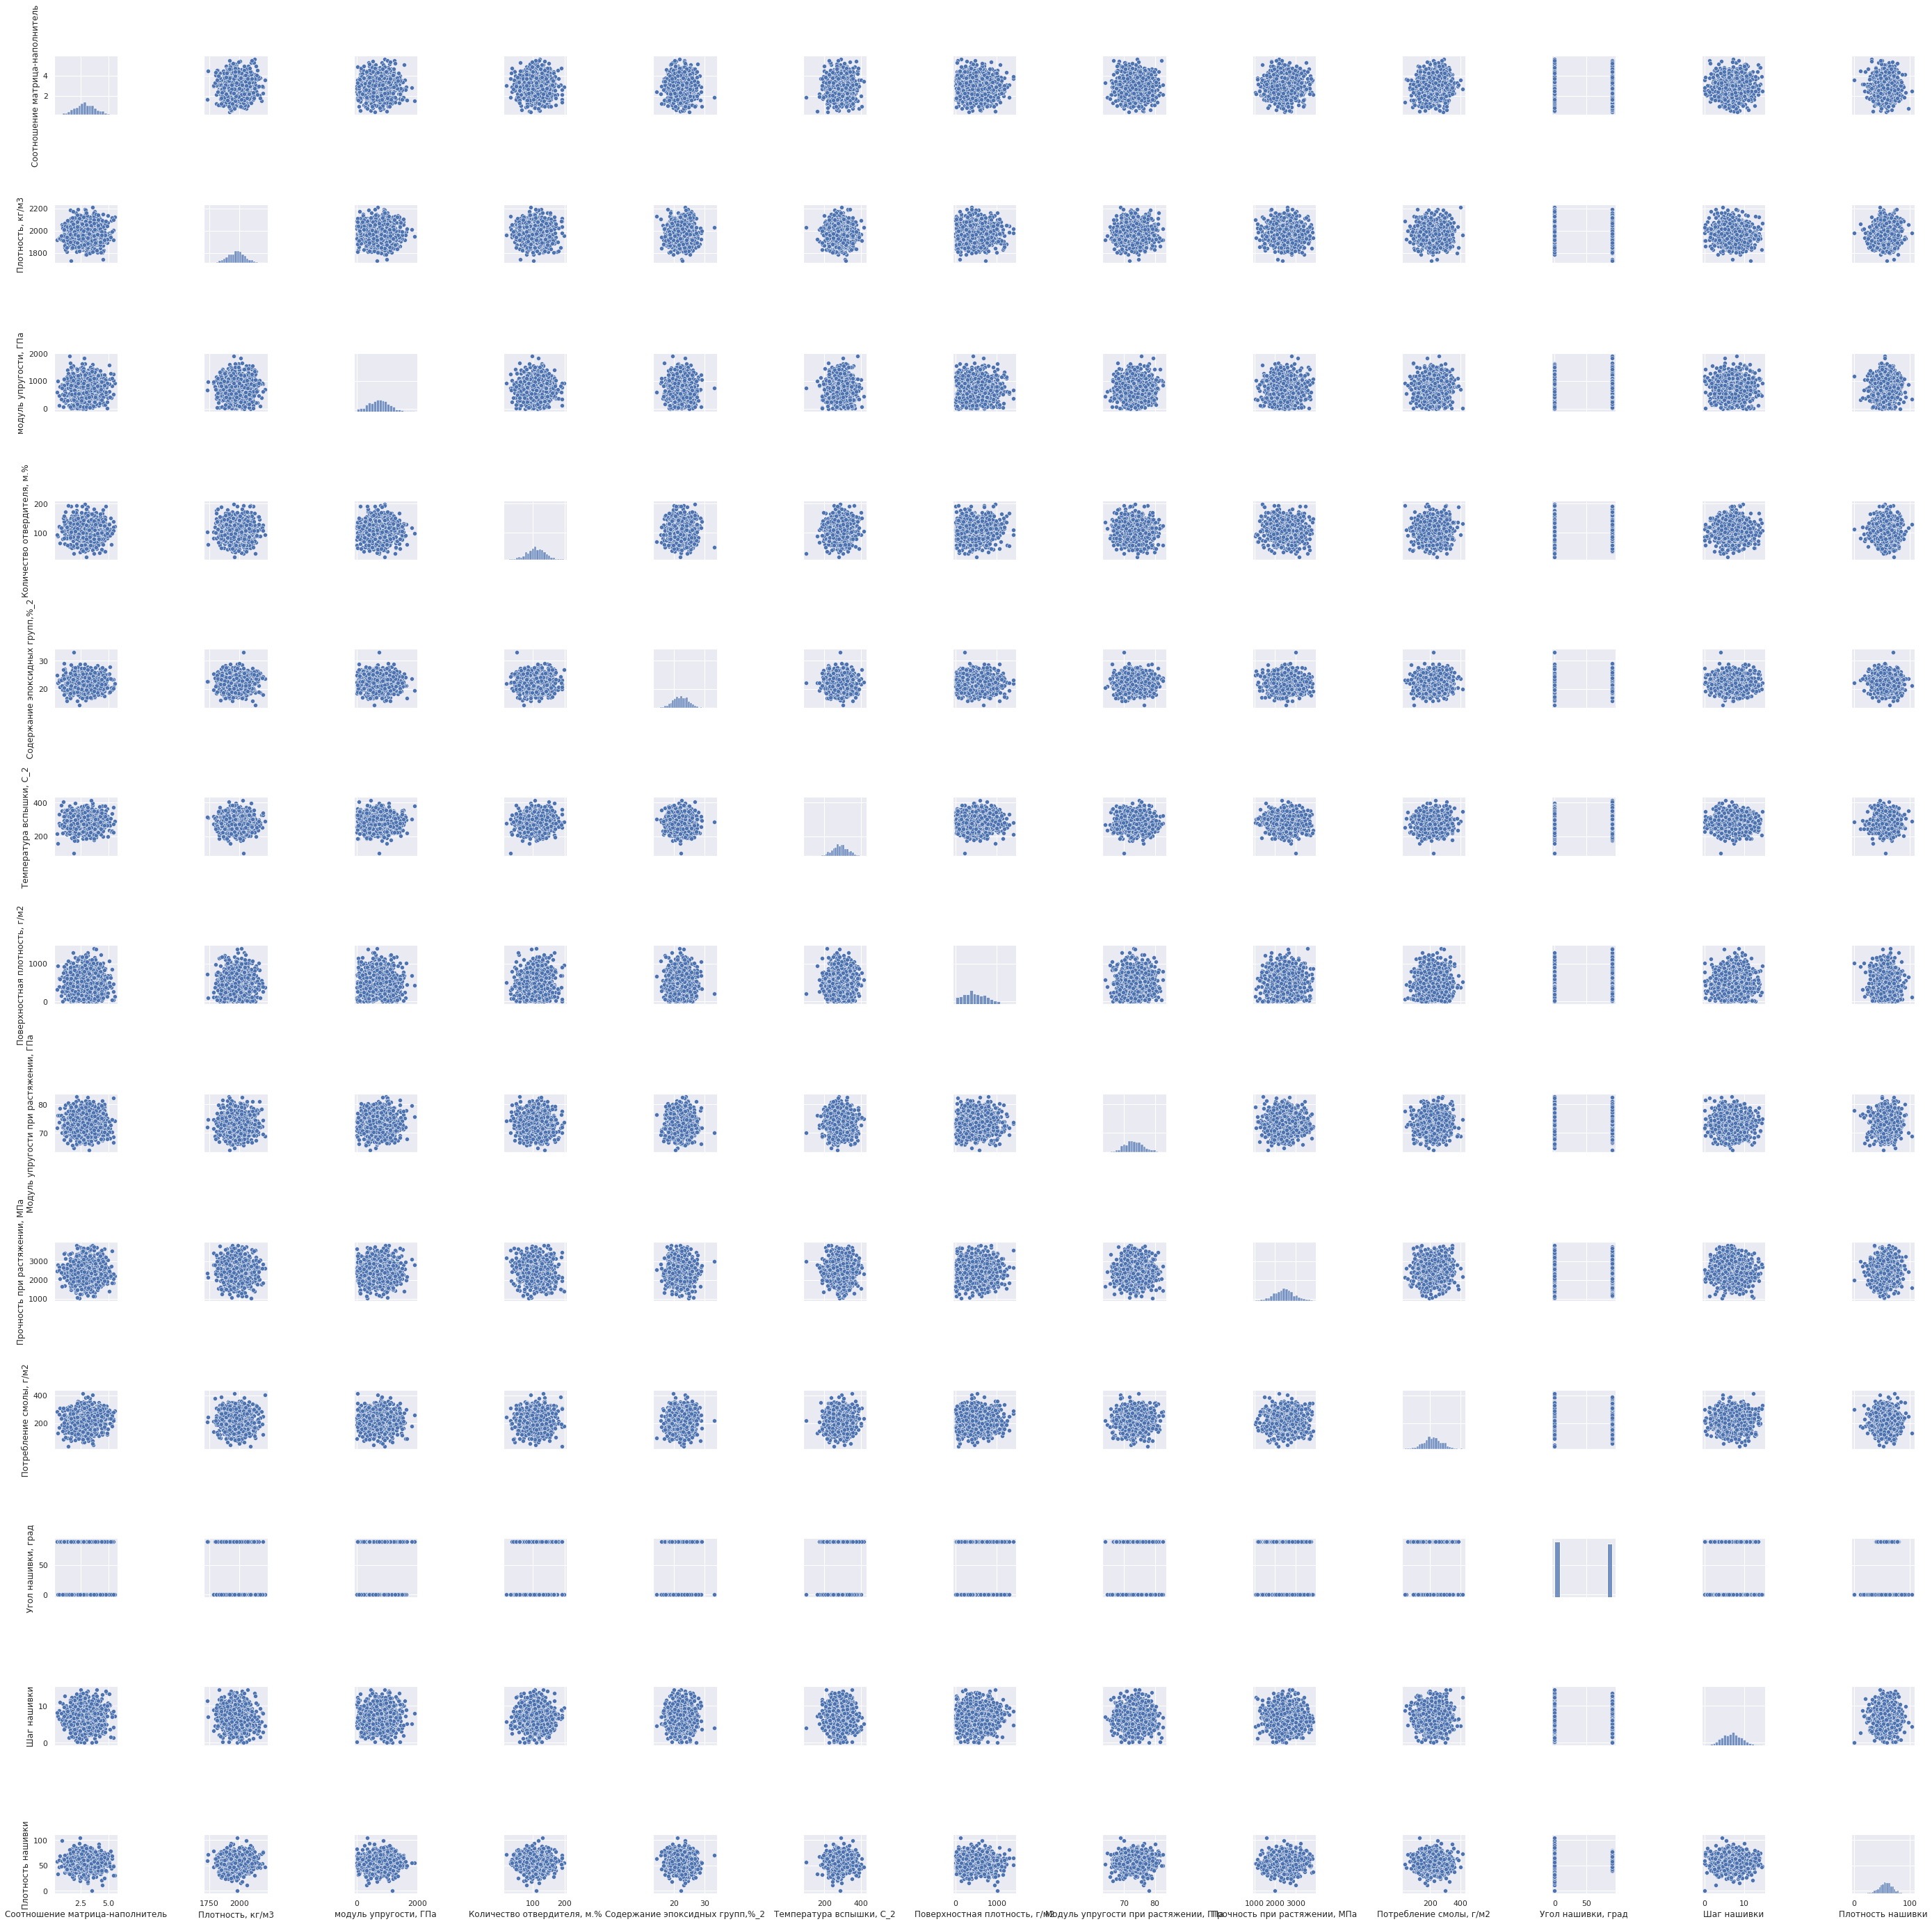

In [194]:
# Строю графики рассеяния
sns.pairplot(df, height=3);

Видно, что выбросы есть. Найдём их, используя 2 способа и сравним

Соотношение матрица-наполнитель: 3s=0 iq=6


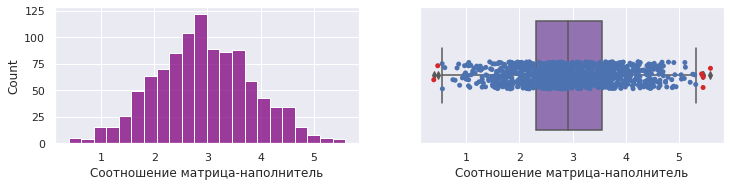

Плотность, кг/м3: 3s=3 iq=9


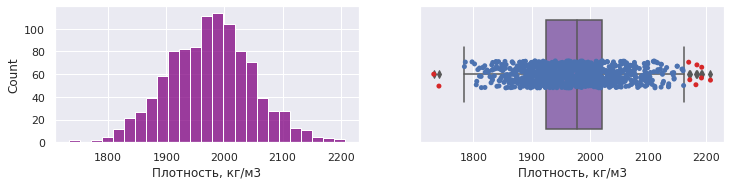

модуль упругости, ГПа: 3s=2 iq=2


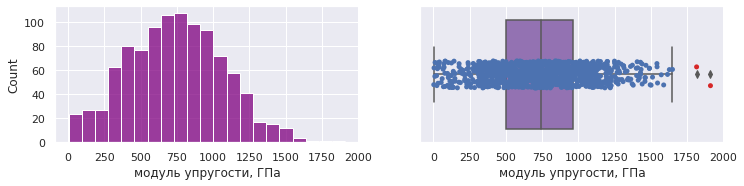

Количество отвердителя, м.%: 3s=2 iq=14


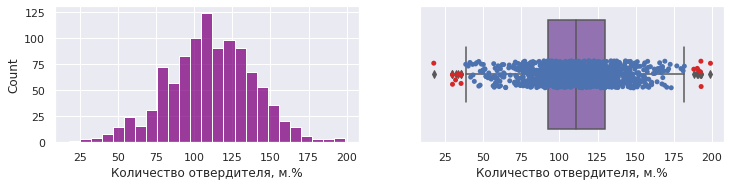

Содержание эпоксидных групп,%_2: 3s=2 iq=2


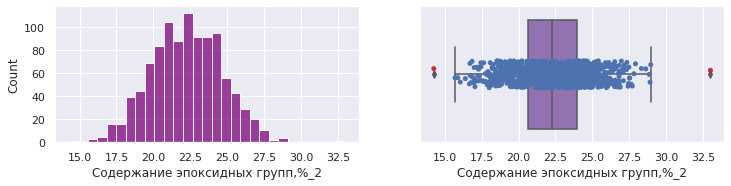

Температура вспышки, С_2: 3s=3 iq=8


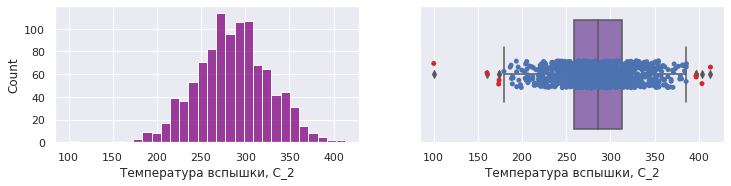

Поверхностная плотность, г/м2: 3s=2 iq=2


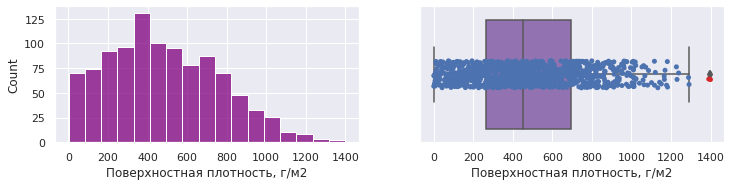

Модуль упругости при растяжении, ГПа: 3s=0 iq=6


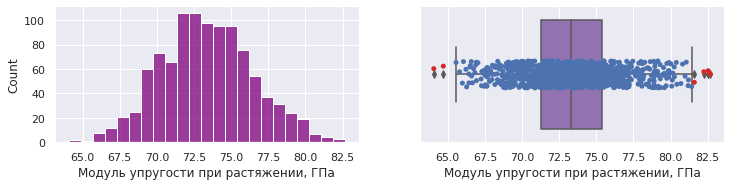

Прочность при растяжении, МПа: 3s=0 iq=11


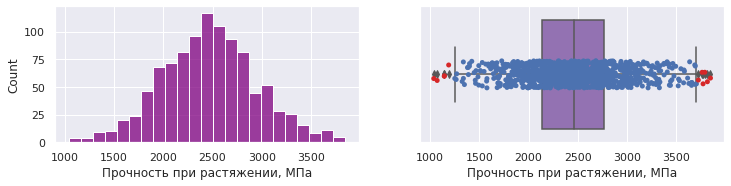

Потребление смолы, г/м2: 3s=3 iq=8


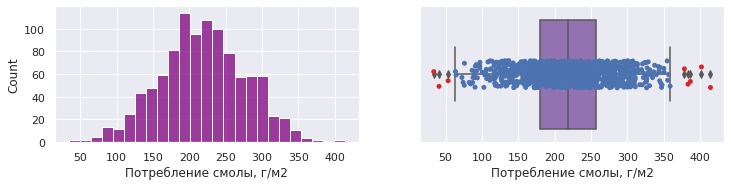

Угол нашивки, град: 3s=0 iq=0


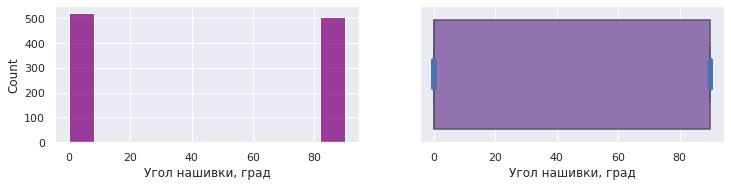

Шаг нашивки: 3s=0 iq=4


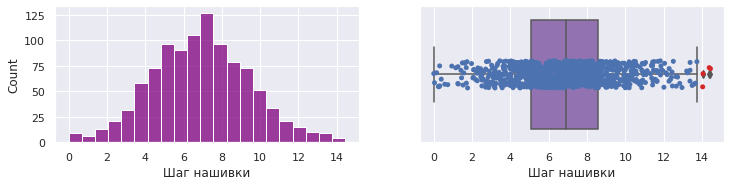

Плотность нашивки: 3s=7 iq=21


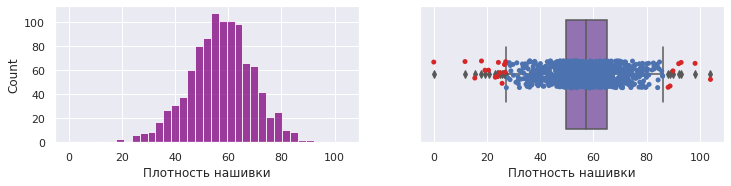

Метод 3-х сигм, выбросов: 24
Метод межквартильных расстояний, выбросов: 93


In [195]:
count_3s = 0
count_iq = 0
for column in df:
    d = df.loc[:, [column]]
    # методо 3-х сигм
    zscore = (df[column] - df[column].mean()) / df[column].std()
    d['3s'] = zscore.abs() > 3
    count_3s += d['3s'].sum()
    # методо межквартильных расстояний
    q1 = np.quantile(df[column], 0.25)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    d['iq'] = (df[column] <= lower) | (df[column] >= upper)
    count_iq += d['iq'].sum()
    # визуализация выбросов
    print('{}: 3s={} iq={}'.format(column, d['3s'].sum(), d['iq'].sum()))
    fig, axes = plt.subplots(1, 2, figsize=(12, 2.5))
    sns.histplot(data=d, x=column, color='purple', multiple='stack', legend=False, ax=axes[0])
    sns.boxplot(data=d, x=column, color='tab:purple', ax=axes[1])
    sns.stripplot(data=d[d['iq']==False], x=column, ax=axes[1])
    sns.stripplot(data=d[d['iq']==True], x=column, color='tab:red', ax=axes[1])
    plt.show()

print('Метод 3-х сигм, выбросов:', count_3s)
print('Метод межквартильных расстояний, выбросов:', count_iq)

Удаляю выбросы методом 3х сигм:

In [196]:
# Удалить выбросы методом 3-х сигм
outliers = pd.DataFrame(index=df.index)
for column in df:
    zscore = (df[column] - df[column].mean()) / df[column].std()
    outliers[column] = (zscore.abs() > 3)
df = df[outliers.sum(axis=1)==0]
df.shape

(1000, 13)

In [197]:
# Сохраняю очищенный датасет
df.to_excel(data_path + 'clean_data.xlsx')

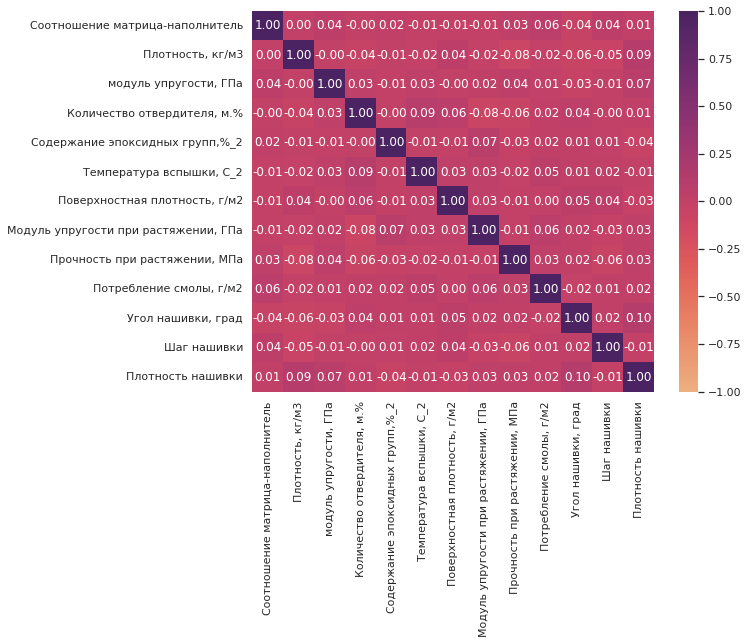

In [198]:
# Строим матрицу корреляций.
corr = df.corr()
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='flare', ax=ax)
plt.show()

По матрице видно, что линейные связи отсутствуют

Далее построим модели

In [199]:
# Загружаем данные
df = pd.read_excel(data_path + 'data_cleaned.xlsx', index_col=0)
df

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
1,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,3000.000000,220.000000,0,4.000000,60.000000
3,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,3000.000000,220.000000,0,5.000000,47.000000
4,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0,5.000000,57.000000
5,2.767918,2000.000000,748.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0,5.000000,60.000000
6,2.569620,1910.000000,807.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0,5.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,2387.292495,125.007669,90,9.076380,47.019770
1019,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,2360.392784,117.730099,90,10.565614,53.750790
1020,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764,90,4.161154,67.629684
1021,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,2071.715856,197.126067,90,6.313201,58.261074


Разделим данные на 3 группы

In [200]:
#Данные для 1 задачи
y1_columns = ['Модуль упругости при растяжении, ГПа']
x1_columns = [
  'Соотношение матрица-наполнитель', 
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [201]:
y1 = df.loc[:, y1_columns]
x1 = df.loc[:, x1_columns]

In [202]:
# Даныне для 2 задачи
y2_columns = ['Прочность при растяжении, МПа']
x2_columns = [
  'Соотношение матрица-наполнитель', 
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [203]:
y2 = df.loc[:, y2_columns]
x2 = df.loc[:, x2_columns]

In [204]:
# Данные для 3 задачи
y3_columns = ['Соотношение матрица-наполнитель']
x3_columns = [
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Модуль упругости при растяжении, ГПа',
  'Прочность при растяжении, МПа', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [205]:
y3 = df.loc[:, y3_columns]
x3 = df.loc[:, x3_columns]

Препроцессинг данных

In [206]:
# Выделяем категориальные переменные
x_categorical = ['Угол нашивки, град']
x1_continuous = [column for column in x1_columns if column not in x_categorical]
x2_continuous = [column for column in x2_columns if column not in x_categorical]
x3_continuous = [column for column in x3_columns if column not in x_categorical]

In [207]:
# Задача 1
preprocessor1 = ColumnTransformer(transformers=[
        ("continuous", StandardScaler(), x1_continuous),
        ("categorical", OrdinalEncoder(), x_categorical)
])

In [208]:
# Задача 2
preprocessor2 = ColumnTransformer(transformers=[
        ("continuous", StandardScaler(), x2_continuous),
        ("categorical", OrdinalEncoder(), x_categorical)
])

In [209]:
# Задача 3
preprocessor3 = ColumnTransformer(transformers=[
        ("continuous", StandardScaler(), x3_continuous),
        ("categorical", OrdinalEncoder(), x_categorical)
])

In [210]:
def show_statistics(d):
    return d.describe().loc[['min', 'max', 'mean', 'std'], :].style.format(precision=6)

Строим модели

Пробуем разные модели и используем кросс-валидацию

In [211]:
def run_models(models, x, y):
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=RANDOM_STATE)
    scoring = ['r2', 
                'max_error', 
                'neg_root_mean_squared_error', 
                'neg_mean_absolute_error', 
                'neg_mean_absolute_percentage_error']
    for model_name, model in models.items():
        scores = cross_validate(model, x, y, cv=cv, scoring=scoring)
        stat.loc[model_name, 'R2'] = scores['test_r2'].mean()
        stat.loc[model_name, 'RMSE'] = scores['test_neg_root_mean_squared_error'].mean()
        stat.loc[model_name, 'MAE'] = scores['test_neg_mean_absolute_error'].mean()
        stat.loc[model_name, 'MAPE'] = scores['test_neg_mean_absolute_percentage_error'].mean()
        stat.loc[model_name, 'max_error'] = scores['test_max_error'].mean()
    return stat

In [212]:
def run_grid_search(model, params, x, y):
    pd.options.display.max_colwidth = 200
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=RANDOM_STATE)
    # scoring = 'neg_root_mean_squared_error'
    scoring = 'neg_mean_absolute_error'
    searcher = GridSearchCV(model, params, cv=cv, scoring=scoring)
    searcher.fit(x, y)
    stat.loc[:, 'params'] = searcher.cv_results_['params']
    stat.loc[:, 'MAE'] = searcher.cv_results_['mean_test_score']
    stat.loc[:, 'rank'] = searcher.cv_results_['rank_test_score']
    return stat, searcher.best_estimator_

In [213]:
def get_metrics(model_name, y, y_pred):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(y, y_pred)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(y, y_pred, squared=False) * -1
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(y, y_pred) * -1
    stat.loc[model_name, 'MAPE'] = metrics.mean_absolute_percentage_error(y, y_pred) * -1
    stat.loc[model_name, 'max_error'] = metrics.max_error(y, y_pred) * -1
    return stat

In [214]:
# Отделяем тренировочную выборку (30%)
x1_train_raw, x1_test_raw, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=RANDOM_STATE)
print('x1_train:', x1_train_raw.shape, 'y1_train:', y1_train.shape)
print('x1_test:', x1_test_raw.shape, 'y1_test:', y1_test.shape)

x1_train: (700, 11) y1_train: (700, 1)
x1_test: (300, 11) y1_test: (300, 1)


In [215]:
x1_train = preprocessor1.fit_transform(x1_train_raw)
x1_test = preprocessor1.transform(x1_test_raw)

In [216]:
y1_train = y1_train['Модуль упругости при растяжении, ГПа'].values
y1_test = y1_test['Модуль упругости при растяжении, ГПа'].values

In [217]:
show_statistics(x1_train_raw)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
min,0.547391,1784.482245,2.436909,32.019222,15.695894,173.973907,1.668002,41.048278,0.000000,0.037639,20.571633
max,5.591742,2192.738783,1649.415706,192.851702,28.907470,403.652861,1291.340115,386.903431,90.000000,14.440522,92.963492
mean,2.917162,1974.717828,741.430997,110.674459,22.193587,285.564200,480.126001,218.324283,44.357143,6.880148,57.037893
std,0.899362,73.123676,329.247055,27.794199,2.423478,39.743461,277.206968,59.270483,45.027582,2.589354,12.335299


In [218]:
# Описательная статистика
show_statistics(pd.DataFrame(x1_train, columns=(x1_continuous + x_categorical)))

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,"Угол нашивки, град"
min,-2.636831,-2.603420,-2.246102,-2.831939,-2.683061,-2.809773,-1.727230,-2.993105,-2.644444,-2.958366,0.000000
max,2.975990,2.983669,2.759733,2.958747,2.772331,2.973397,2.928477,2.846268,2.921880,2.914505,1.000000
mean,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.492857
std,1.000715,1.000715,1.000715,1.000715,1.000715,1.000715,1.000715,1.000715,1.000715,1.000715,0.500306


In [219]:
# Описательная статистика
show_statistics(pd.DataFrame(y1_train))

,0
min,64.696400
max,82.682051
mean,73.260889
std,3.187845


In [220]:
# Сравнение моделей
def_models1 = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'RandomForestRegressor': RandomForestRegressor(random_state=RANDOM_STATE)
}

stat1_1 = run_models(def_models1, x1_train, y1_train)
stat1_1.style.highlight_max(axis=0)

,R2,RMSE,MAE,MAPE,max_error
DummyRegressor,-0.017503,-3.186362,-2.577241,-0.035208,-8.102476
LinearRegression,-0.020523,-3.190297,-2.579050,-0.035238,-7.862138
Ridge,-0.020451,-3.190189,-2.578970,-0.035237,-7.862214
Lasso,-0.017503,-3.186362,-2.577241,-0.035208,-8.102476
SVR,-0.067018,-3.260509,-2.644430,-0.036101,-8.261335
KNeighborsRegressor,-0.272746,-3.556164,-2.873813,-0.039239,-8.996221
DecisionTreeRegressor,-1.038215,-4.494619,-3.567526,-0.048735,-11.561826
RandomForestRegressor,-0.064976,-3.258583,-2.618198,-0.035770,-8.179704


Ни одна из выбранных моделей не подходит

In [221]:
# Приступаем к поиску лучших моделей
s_models1 = {}

In [222]:
params1 = [
  {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'alpha': range(10, 1510, 10)
  },           
  {
    'solver': ['lbfgs'],
    'alpha': range(10, 1510, 10),
    'positive': [True]
  }
]
search, smodel = run_grid_search(Ridge(), params1, x1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
768,"{'alpha': 190, 'positive': True, 'solver': 'lbfgs'}",-2.565061,1


In [223]:
params1 = [
  {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.095, 0.1, 0.150, 0.2, 0.5, 1]
  }
]
search, smodel = run_grid_search(Lasso(), params1, x1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
6,{'alpha': 0.15},-2.558057,1


In [224]:
params1 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['rbf'],
      'C': [0.01, 0.02, 0.03, 0.04]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.01, 0.02, 0.03, 0.04, 0.5]
    }
]
search, smodel = run_grid_search(SVR(), params1, x1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
13,"{'C': 0.01, 'kernel': 'sigmoid'}",-2.570115,1


In [225]:
params1 = {
    'n_neighbors': range(3, 31, 2)
}
search, smodel = run_grid_search(KNeighborsRegressor(), params1, x1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
11,{'n_neighbors': 25},-2.626554,1


In [226]:
params1 = {
    'random_state': [RANDOM_STATE],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3],
    'max_features': range(1, 11, 1)
}
search, smodel = run_grid_search(DecisionTreeRegressor(), params1, x1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
139,"{'criterion': 'absolute_error', 'max_depth': 1, 'max_features': 10, 'random_state': 3000, 'splitter': 'random'}",-2.548433,1


In [227]:
params1 = {
    'random_state': [RANDOM_STATE],
    'n_estimators': [50, 100], 
    'criterion': ['absolute_error'],
    'max_depth': [2, 3, 4, 5],
    'max_features': [1, 2, 11],
    'bootstrap': [False]
}
search, smodel = run_grid_search(RandomForestRegressor(), params1, x1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==10]

,params,MAE,rank
6,"{'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 1, 'n_estimators': 50, 'random_state': 3000}",-2.575788,10


In [228]:
# Сравнение моделей с подобранными параметрами, поиск лучшей
stat1_2 = run_models(s_models1, x1_train, y1_train)
stat1_2.style.highlight_max(axis=0)

,R2,RMSE,MAE,MAPE,max_error
"Ridge(alpha=190, positive=True, solver='lbfgs')",-0.013871,-3.181261,-2.565061,-0.035042,-7.978964
Lasso(alpha=0.15),-0.008472,-3.171853,-2.558057,-0.034949,-7.963249
"SVR(C=0.01, kernel='sigmoid')",-0.020800,-3.191391,-2.570115,-0.034997,-8.187845
KNeighborsRegressor(n_neighbors=25),-0.052917,-3.241117,-2.626554,-0.035896,-8.053540
"DecisionTreeRegressor(criterion='absolute_error', max_depth=1, max_features=10, random_state=3000, splitter='random')",-0.012640,-3.179297,-2.548433,-0.034745,-8.124815
"RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=5, max_features=1, random_state=3000)",-0.015018,-3.182506,-2.567720,-0.035011,-8.111738


In [229]:
# Предсказание базовой модели
base_model1 = DummyRegressor(strategy='mean')
base_model1.fit(x1_train, y1_train)
y1_pred_base = base_model1.predict(x1_test)

In [230]:
# Предсказание лучшей модели
best_model1 = DecisionTreeRegressor(criterion='absolute_error', max_depth=2, max_features=10, random_state=RANDOM_STATE, splitter='random')
best_model1.fit(x1_train, y1_train)
y1_pred_best = best_model1.predict(x1_test)

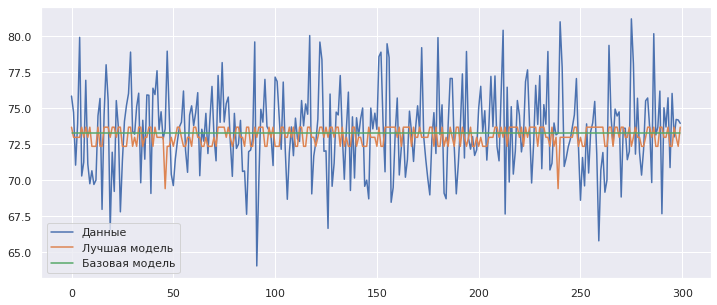

In [231]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y1_test, label='Данные')
ax.plot(y1_pred_best, label='Лучшая модель')
ax.plot(y1_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [232]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare1 = get_metrics('Базовая модель', y1_test, y1_pred_base)
compare1 = compare1.append(get_metrics('Лучшая модель (дерево решений)', y1_test, y1_pred_best))
compare1

,R2,RMSE,MAE,MAPE,max_error
Базовая модель,-0.004248,-2.935959,-2.311180,-0.031448,-9.206829
Лучшая модель (дерево решений),-0.057729,-3.013120,-2.388221,-0.032446,-8.913120


### Модель для прочности при растяжении, МПа

In [233]:
# Разделяем на тренировочную и тестовую выборку
x2_train_raw, x2_test_raw, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=RANDOM_STATE)
print('x2_train:', x2_train_raw.shape, 'y2_train:', y2_train.shape)
print('x2_test:', x2_test_raw.shape, 'y2_test:', y2_test.shape)

x2_train: (700, 11) y2_train: (700, 1)
x2_test: (300, 11) y2_test: (300, 1)


In [234]:
# Выполняю препроцессинг входных переменных
x2_test = preprocessor2.fit_transform(x2_test_raw)
x2_train = preprocessor2.transform(x2_train_raw)

In [235]:
# Выходная переменная преобразованиям не подвергается
y2_train = y2_train['Прочность при растяжении, МПа'].values
y2_test = y2_test['Прочность при растяжении, МПа'].values

In [236]:
# Описательная статистика входных данных до предобработки
show_statistics(x2_train_raw)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
min,0.547391,1784.482245,2.436909,32.019222,15.695894,173.973907,1.668002,41.048278,0.000000,0.037639,20.571633
max,5.591742,2192.738783,1649.415706,192.851702,28.907470,403.652861,1291.340115,386.903431,90.000000,14.440522,92.963492
mean,2.917162,1974.717828,741.430997,110.674459,22.193587,285.564200,480.126001,218.324283,44.357143,6.880148,57.037893
std,0.899362,73.123676,329.247055,27.794199,2.423478,39.743461,277.206968,59.270483,45.027582,2.589354,12.335299


In [237]:
# Описательная статистика входных данных после предобработки
show_statistics(pd.DataFrame(x2_train, columns=(x2_continuous + x_categorical)))

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,"Угол нашивки, град"
min,-2.620063,-2.654283,-2.256299,-2.822480,-2.902003,-2.731570,-1.712456,-3.043048,-2.798773,-3.516107,0.000000
max,2.810871,2.974436,2.835549,2.913025,2.874216,2.825389,2.912133,2.901616,3.006285,3.315112,1.000000
mean,-0.068680,-0.031465,0.028397,-0.017527,-0.061154,-0.031703,0.003229,0.004026,-0.040911,-0.074988,0.492857
std,0.968286,1.008171,1.017910,0.991179,1.059566,0.961572,0.994027,1.018759,1.043635,1.164014,0.500306


In [238]:
# Описательная статистика выходной переменной
show_statistics(pd.DataFrame(y2_train))

,0
min,1036.856605
max,3848.436732
mean,2471.618045
std,469.914107


In [239]:
# Запускаю различные модели с параметрами по умолчанию
models2_def = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=RANDOM_STATE)    
}

stat2_1 = run_models(models2_def, x2_train, y2_train)
stat2_1.style.highlight_max(axis=0)

,R2,RMSE,MAE,MAPE,max_error
DummyRegressor,-0.006553,-468.658864,-366.295334,-0.159655,-1212.095672
LinearRegression,-0.016648,-470.961027,-368.694485,-0.160464,-1221.121186
Ridge,-0.016582,-470.946018,-368.679898,-0.160458,-1221.095783
Lasso,-0.014445,-470.457919,-368.243356,-0.160292,-1220.374412
SVR,-0.006839,-468.735873,-366.284579,-0.158971,-1213.626355
DecisionTreeRegressor,-1.246056,-694.760257,-561.896566,-0.238594,-1678.445027
GradientBoostingRegressor,-0.129170,-496.217004,-393.093501,-0.170809,-1279.940136


In [240]:
# Поиск лучших моделей
s_models2 = {}

In [241]:
params2 = [
  {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'alpha': range(10, 1000, 10)
  },
  {
    'solver': ['sag', 'saga'],
    'alpha': range(10, 1000, 10),
    'random_state': [RANDOM_STATE]
  },
  {
    'solver': ['lbfgs'],
    'alpha': range(10, 1000, 10),
    'positive': [True]
  }
]
search, smodel = run_grid_search(Ridge(), params2, x2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
493,"{'alpha': 990, 'solver': 'lsqr'}",-366.150582,1


In [242]:
params2 = [
  {
    'alpha': [0.1, 1, 5, 10, 20, 30, 40, 50, 60, 100]
  }
]
search, smodel = run_grid_search(Lasso(), params2, x2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
4,{'alpha': 20},-365.624161,1


In [243]:
params2 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['rbf'],
      'gamma': ['scale', 'auto'],
      'C': [0.01, 0.05, 0.1, 0.2, 0.3]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.001, 0.01, 0.1]
    }
]

search, smodel = run_grid_search(SVR(), params2, x2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
18,"{'C': 0.1, 'kernel': 'sigmoid'}",-366.132051,1


In [244]:
params2 = {
    'random_state': [RANDOM_STATE],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3],
    'max_features': range(1, 11, 1)
}
search, smodel = run_grid_search(DecisionTreeRegressor(), params2, x2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
153,"{'criterion': 'absolute_error', 'max_depth': 2, 'max_features': 7, 'random_state': 3000, 'splitter': 'random'}",-365.193786,1


In [245]:
params2 = {
    'random_state': [RANDOM_STATE],
    'loss': ['squared_error', 'absolute_error'], 
    #'criterion': ['friedman_mse', 'squared_error'],
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 2, 3],
    'max_features': [1, 2, 5, 11]    
}
search, smodel = run_grid_search(GradientBoostingRegressor(), params2, x2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
6,"{'loss': 'squared_error', 'max_depth': 1, 'max_features': 5, 'n_estimators': 50, 'random_state': 3000}",-366.422433,1


In [246]:
# Сравнение моделей с подобранными параметрами, поиск лучшей
stat2_2 = run_models(s_models2, x2_train, y2_train)
stat2_2.style.highlight_max(axis=0)

,R2,RMSE,MAE,MAPE,max_error
"Ridge(alpha=990, solver='lsqr')",-0.004890,-468.297495,-366.150582,-0.159540,-1213.516575
Lasso(alpha=20),-0.002922,-467.845362,-365.624161,-0.159328,-1210.853317
"SVR(C=0.1, kernel='sigmoid')",-0.006598,-468.678519,-366.132051,-0.158915,-1213.518131
"DecisionTreeRegressor(criterion='absolute_error', max_depth=2, max_features=7, random_state=3000, splitter='random')",-0.009668,-469.247651,-365.193786,-0.158561,-1255.728245
"GradientBoostingRegressor(max_depth=1, max_features=5, n_estimators=50, random_state=3000)",-0.010178,-469.515764,-366.422433,-0.159592,-1195.992639


In [247]:
# Предсказание базовой модели
base_model2 = DummyRegressor(strategy='mean')
base_model2.fit(x2_train, y2_train)
y2_pred_base = base_model2.predict(x2_test)

In [248]:
# Предсказание лучшей модели
best_model2 = GradientBoostingRegressor(max_depth=1, max_features=1, n_estimators=50, random_state=RANDOM_STATE)
best_model2.fit(x2_train, y2_train)
y2_pred_best = best_model2.predict(x2_test)

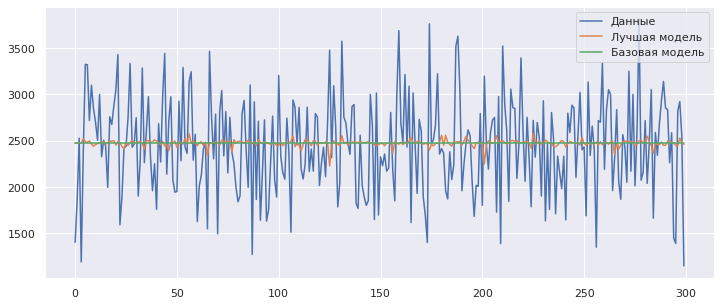

In [249]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y2_test, label='Данные')
ax.plot(y2_pred_best, label='Лучшая модель')
ax.plot(y2_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [250]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare2 = get_metrics('Базовая модель', y2_test, y2_pred_base)
compare2 = compare2.append(get_metrics('Лучшая модель (градиентный бустинг)', y2_test, y2_pred_best))
compare2

,R2,RMSE,MAE,MAPE,max_error
Базовая модель,-0.001888,-518.644383,-420.661724,-0.190312,-1345.651439
Лучшая модель (градиентный бустинг),-0.003173,-518.976829,-419.371608,-0.189713,-1364.589131


### Модель для соотношения матрица-наполнитель

In [251]:
# Разделяем на тренировочную и тестовую выборку
x3_train_raw, x3_test_raw, y3_train, y3_test = train_test_split(x3, y3, test_size=0.3, random_state=RANDOM_STATE)
print('x3_train:', x3_train_raw.shape, 'y3_train:', y3_train.shape)
print('x3_test:', x3_test_raw.shape, 'y3_test:', y3_test.shape)

x3_train: (700, 12) y3_train: (700, 1)
x3_test: (300, 12) y3_test: (300, 1)


In [252]:
# Выполняю препроцессинг входных переменных
x3_test = preprocessor3.fit_transform(x3_test_raw)
x3_train = preprocessor3.transform(x3_train_raw)

In [253]:
# Выходная переменная преобразованиям не подвергается
y3_train = y3_train['Соотношение матрица-наполнитель'].values
y3_test = y3_test['Соотношение матрица-наполнитель'].values

In [254]:
# Описательная статистика входных данных до предобработки
show_statistics(x3_train_raw)

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
min,1784.482245,2.436909,32.019222,15.695894,173.973907,1.668002,64.696400,1036.856605,41.048278,0.000000,0.037639,20.571633
max,2192.738783,1649.415706,192.851702,28.907470,403.652861,1291.340115,82.682051,3848.436732,386.903431,90.000000,14.440522,92.963492
mean,1974.717828,741.430997,110.674459,22.193587,285.564200,480.126001,73.260889,2471.618045,218.324283,44.357143,6.880148,57.037893
std,73.123676,329.247055,27.794199,2.423478,39.743461,277.206968,3.187845,469.914107,59.270483,45.027582,2.589354,12.335299


In [255]:
# Описательная статистика входных данных после предобработки
show_statistics(pd.DataFrame(x3_train, columns=(x3_continuous + x_categorical)))

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,"Угол нашивки, град"
min,-2.654283,-2.256299,-2.822480,-2.902003,-2.731570,-1.712456,-2.988472,-2.725530,-3.043048,-2.798773,-3.516107,0.000000
max,2.974436,2.835549,2.913025,2.874216,2.825389,2.912133,3.150517,2.700601,2.901616,3.006285,3.315112,1.000000
mean,-0.031465,0.028397,-0.017527,-0.061154,-0.031703,0.003229,-0.065180,0.043448,0.004026,-0.040911,-0.074988,0.492857
std,1.008171,1.017910,0.991179,1.059566,0.961572,0.994027,1.088098,0.906898,1.018759,1.043635,1.164014,0.500306


In [256]:
# Описательная статистика выходной переменной
show_statistics(pd.DataFrame(y3_train))

,0
min,0.547391
max,5.591742
mean,2.917162
std,0.899362


In [257]:
# Базовая модель
base_model3 = DummyRegressor(strategy='mean')

In [258]:
# Предсказание базовой модели
base_model3.fit(x3_train, y3_train)
y3_pred_base = base_model3.predict(x3_test)

In [259]:
from sklearn.neural_network import MLPRegressor

In [260]:
# Настраиваю нейросеть
model3_1 = MLPRegressor(
    hidden_layer_sizes = (24, 24, 24, 24, 24, 24, 24, 24),
    activation = 'relu',
    solver='adam',
    max_iter=5000,
    early_stopping = True,
    validation_fraction = 0.3,
    random_state=RANDOM_STATE, 
    verbose=True
)

In [261]:
%%time
# Запускаю нейросеть
model3_1.fit(x3_train, y3_train)

Iteration 1, loss = 4.06059583
Validation score: -9.638798
Iteration 2, loss = 3.70753615
Validation score: -8.676922
Iteration 3, loss = 3.37627407
Validation score: -7.825113
Iteration 4, loss = 3.07841378
Validation score: -7.023902
Iteration 5, loss = 2.79547975
Validation score: -6.239673
Iteration 6, loss = 2.51705462
Validation score: -5.488560
Iteration 7, loss = 2.25115302
Validation score: -4.749795
Iteration 8, loss = 1.99050634
Validation score: -4.027406
Iteration 9, loss = 1.73392030
Validation score: -3.293522
Iteration 10, loss = 1.47097459
Validation score: -2.532014
Iteration 11, loss = 1.19324198
Validation score: -1.747331
Iteration 12, loss = 0.91809533
Validation score: -1.007792
Iteration 13, loss = 0.66696984
Validation score: -0.493100
Iteration 14, loss = 0.50893163
Validation score: -0.395407
Iteration 15, loss = 0.51003503
Validation score: -0.574413
Iteration 16, loss = 0.55790845
Validation score: -0.547663
Iteration 17, loss = 0.53311186
Validation score:

MLPRegressor(early_stopping=True,
             hidden_layer_sizes=(24, 24, 24, 24, 24, 24, 24, 24), max_iter=5000,
             random_state=3000, validation_fraction=0.3, verbose=True)

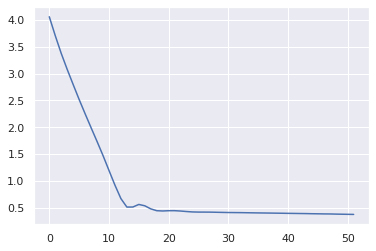

In [262]:
# График ошибки
plt.plot(model3_1.loss_curve_)
plt.grid(True)
plt.show()

In [263]:
# Предсказание нейросети
y3_pred_skl = model3_1.predict(x3_test)

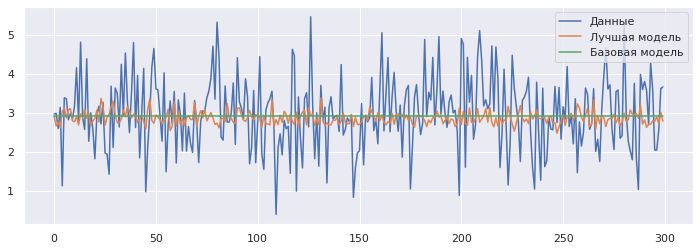

In [264]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_skl, label='Лучшая модель')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [265]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare3_1 = get_metrics('DummyRegressor', y3_test, y3_pred_base)
compare3_1 = compare3_1.append(get_metrics('MLPRegressor', y3_test, y3_pred_skl))
compare3_1

,R2,RMSE,MAE,MAPE,max_error
DummyRegressor,-0.004717,-0.931006,-0.731585,-0.318782,-2.538405
MLPRegressor,-0.059056,-0.955851,-0.747762,-0.318292,-2.585054


In [266]:
# Попробую построить нейронную сеть с помощью библиотеки TensorFlow.

In [267]:
# Функция, собирающая нейросеть заданной архитектуры
def construct_model():
    return tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                   
      keras.layers.Dense(units=24, activation='relu', name='dense_1'),
      keras.layers.Dense(units=24, activation='relu', name='dense_2'),
      keras.layers.Dense(units=24, activation='relu', name='dense_3'),
      keras.layers.Dense(units=24, activation='relu', name='dense_4'),
      keras.layers.Dense(units=24, activation='relu', name='dense_5'),
      keras.layers.Dense(units=24, activation='relu', name='dense_6'),
      keras.layers.Dense(units=24, activation='relu', name='dense_7'),
      keras.layers.Dense(units=24, activation='relu', name='dense_8'),
      keras.layers.Dense(units=1, name='out')                        
    ])

In [268]:
# Функция, компилирующая нейросеть с заданными параметрами
def compile_model(model):
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.MeanAbsolutePercentageError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model


In [269]:
# Функция для построения графика ошибки
def plot_loss(history):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  axes[0].plot(history['loss'], label='loss')
  axes[0].plot(history['val_loss'], label='val_loss')
  axes[0].set_xlabel('Эпоха')
  axes[0].set_ylabel('MAPE')
  axes[0].legend()
  axes[0].grid(True)
  axes[1].plot(history['root_mean_squared_error'], label='loss')
  axes[1].plot(history['val_root_mean_squared_error'], label='val_loss')
  axes[1].set_xlabel('Эпоха')
  axes[1].set_ylabel('RMSE')
  axes[1].legend()
  axes[1].grid(True)
  plt.show()

In [270]:
# Собираю нейросеть
model3_2 = construct_model()

In [271]:
# Компилирую нейросеть
model3_2 = compile_model(model3_2)

In [272]:
# Сводная информация по архитектуре сети
model3_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 24)                600       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 24)                6

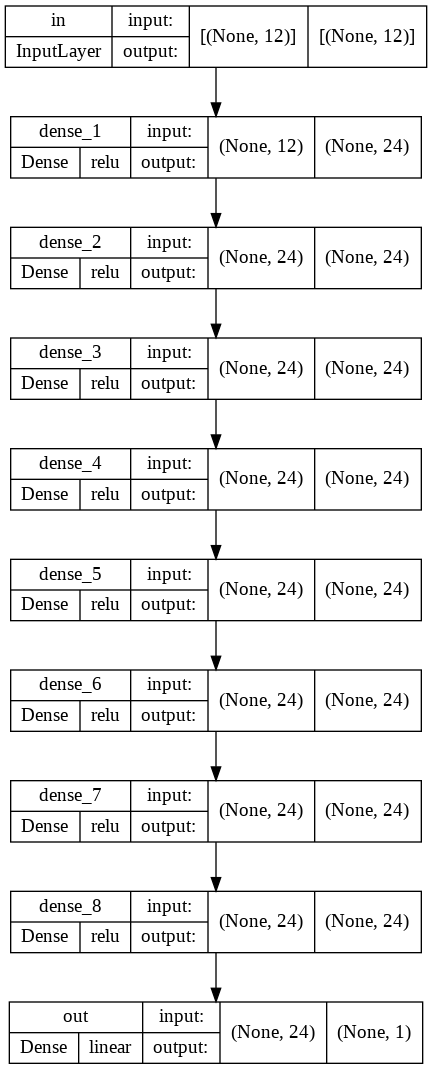

In [273]:
# Архитектура нейросети визуально
keras.utils.plot_model(model3_2, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [274]:
%%time
#Обучение нейросети
history = model3_2.fit(
  x3_train, 
  y3_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1
)

Epoch 1/50
16/16 [==============================] - 1s 19ms/step - loss: 92.9666 - root_mean_squared_error: 2.9020 - val_loss: 79.3568 - val_root_mean_squared_error: 2.4926
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 56.0256 - root_mean_squared_error: 1.9845 - val_loss: 34.9572 - val_root_mean_squared_error: 1.1171
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 37.8381 - root_mean_squared_error: 1.2143 - val_loss: 32.6075 - val_root_mean_squared_error: 1.1741
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 35.2040 - root_mean_squared_error: 1.2248 - val_loss: 30.9629 - val_root_mean_squared_error: 1.0671
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 33.7609 - root_mean_squared_error: 1.1462 - val_loss: 30.6081 - val_root_mean_squared_error: 1.0784
Epoch 6/50
16/16 [==============================] - 0s 5ms/step - loss: 32.5094 - root_mean_squared_error: 1.1092 - val_loss: 30.1726 - val

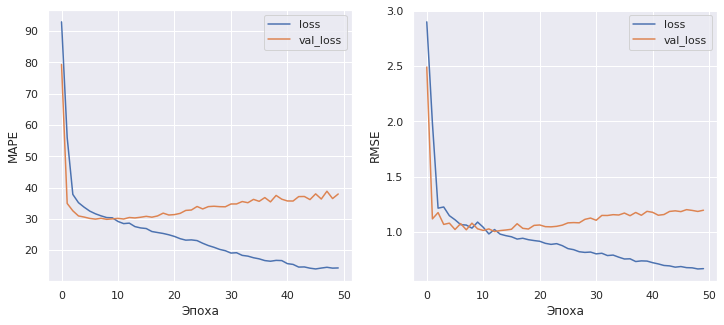

In [275]:
plot_loss(history.history)

In [276]:
# Проверяем точность нейросети на тестовых данных
model3_2.evaluate(x3_test, y3_test)

10/10 [==============================] - 0s 2ms/step - loss: 38.6690 - root_mean_squared_error: 1.1983


[38.668983459472656, 1.1983178853988647]

In [277]:
# Предсказание 
y3_pred_keras2 = model3_2.predict(x3_test)

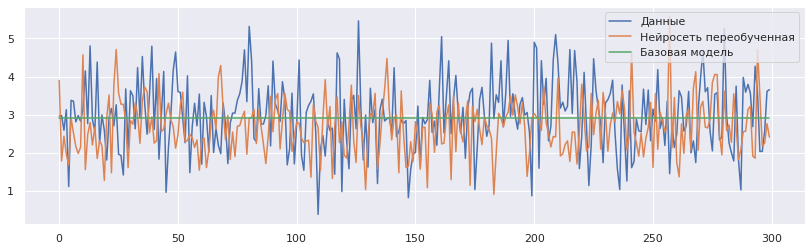

In [278]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_keras2, label='Нейросеть переобученная')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

Попробуем раннюю остановку процесса обучения для борьбы с переобучением

In [279]:
# Создаем модель с той же архитектурой
model3_3 = construct_model()
model3_3 = compile_model(model3_3)

In [280]:
%%time
#Обучение нейросети
history = model3_3.fit(
  x3_train, 
  y3_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/50
16/16 [==============================] - 1s 19ms/step - loss: 75.9916 - root_mean_squared_error: 2.5005 - val_loss: 44.5531 - val_root_mean_squared_error: 1.6153
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 41.4761 - root_mean_squared_error: 1.3321 - val_loss: 33.1165 - val_root_mean_squared_error: 1.0627
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 35.7041 - root_mean_squared_error: 1.2659 - val_loss: 31.1199 - val_root_mean_squared_error: 1.1235
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 32.9569 - root_mean_squared_error: 1.0748 - val_loss: 30.5574 - val_root_mean_squared_error: 1.0607
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 31.9081 - root_mean_squared_error: 1.1304 - val_loss: 30.5463 - val_root_mean_squared_error: 1.0414
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 30.8479 - root_mean_squared_error: 1.0642 - val_loss: 30.2994 - val

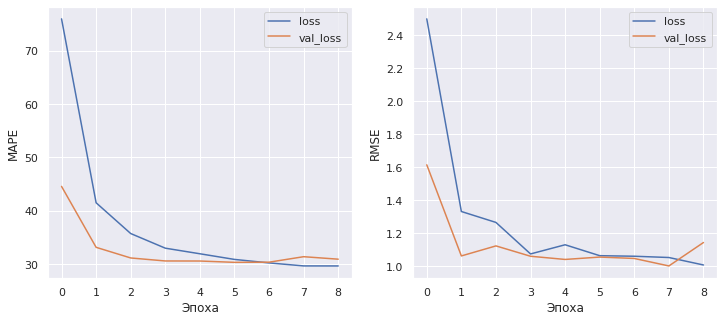

In [281]:
plot_loss(history.history)

In [282]:
# Проверяем точность нейросети на тестовых данных
model3_3.evaluate(x3_test, y3_test)

10/10 [==============================] - 0s 2ms/step - loss: 36.5183 - root_mean_squared_error: 1.2693


[36.51829147338867, 1.2693085670471191]

In [283]:
# Предсказание 
y3_pred_keras3 = model3_3.predict(x3_test)

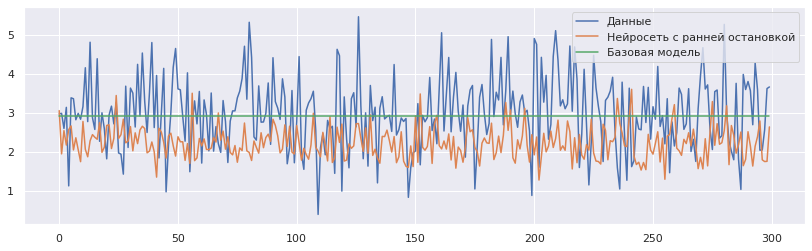

In [284]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_keras3, label='Нейросеть с ранней остановкой')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

Еще одним методом борьбы с переобучением является добавление Dropout-слоя.

In [285]:
# Построение аналогичной модели с Dropout слоем
model3_4 = tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                   
      keras.layers.Dense(units=24, activation='relu', name='dense_1'),
      keras.layers.Dropout(0.05, name='dropout_1'),
      keras.layers.Dense(units=24, activation='relu', name='dense_2'),
      keras.layers.Dropout(0.05, name='dropout_2'),
      keras.layers.Dense(units=24, activation='relu', name='dense_3'),
      keras.layers.Dropout(0.05, name='dropout_3'),
      keras.layers.Dense(units=24, activation='relu', name='dense_4'),
      keras.layers.Dropout(0.05, name='dropout_4'),
      keras.layers.Dense(units=24, activation='relu', name='dense_5'),
      keras.layers.Dropout(0.05, name='dropout_5'),
      keras.layers.Dense(units=24, activation='relu', name='dense_6'),
      keras.layers.Dropout(0.05, name='dropout_6'),
      keras.layers.Dense(units=24, activation='relu', name='dense_7'),
      keras.layers.Dropout(0.05, name='dropout_7'),
      keras.layers.Dense(units=24, activation='relu', name='dense_8'),
      keras.layers.Dropout(0.05, name='dropout_8'),
      keras.layers.Dense(units=1, name='out')                        
    ])

In [286]:
# Компиляция модели
model3_4 = compile_model(model3_4)

In [287]:
# Архитектура изменилась
model3_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 24)               

In [288]:
%%time
#Обучение нейросети
history = model3_4.fit(
  x3_train, 
  y3_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1
)

Epoch 1/50
16/16 [==============================] - 1s 18ms/step - loss: 91.6327 - root_mean_squared_error: 2.8811 - val_loss: 78.5831 - val_root_mean_squared_error: 2.4941
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 56.5900 - root_mean_squared_error: 2.0032 - val_loss: 39.1436 - val_root_mean_squared_error: 1.2948
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 42.7571 - root_mean_squared_error: 1.3792 - val_loss: 34.8613 - val_root_mean_squared_error: 1.2964
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 39.2384 - root_mean_squared_error: 1.4007 - val_loss: 32.8635 - val_root_mean_squared_error: 1.1969
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 36.2999 - root_mean_squared_error: 1.2410 - val_loss: 31.3457 - val_root_mean_squared_error: 1.1715
Epoch 6/50
16/16 [==============================] - 0s 5ms/step - loss: 34.9646 - root_mean_squared_error: 1.2291 - val_loss: 30.1306 - val

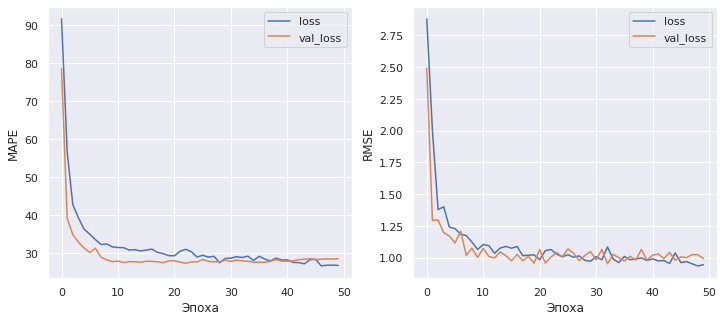

In [289]:
plot_loss(history.history)

In [290]:
# Проверяем точность нейросети на тестовых данных
model3_4.evaluate(x3_test, y3_test)

10/10 [==============================] - 0s 2ms/step - loss: 33.6345 - root_mean_squared_error: 1.1114


[33.6345329284668, 1.111372947692871]

In [291]:
# Предсказание 
y3_pred_keras4 = model3_4.predict(x3_test)

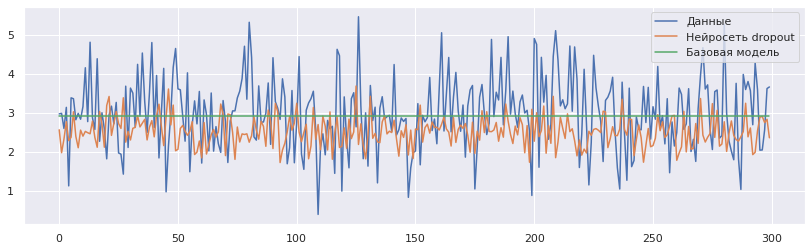

In [292]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_keras4, label='Нейросеть dropout')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [293]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare3_2 = get_metrics('DummyRegressor', y3_test, y3_pred_base)
compare3_2 = compare3_2.append(get_metrics('Нейросеть переобученная', y3_test, y3_pred_keras2))
compare3_2 = compare3_2.append(get_metrics('Нейросеть с ранней остановкой', y3_test, y3_pred_keras3))
compare3_2 = compare3_2.append(get_metrics('Нейросеть dropout', y3_test, y3_pred_keras4))
compare3_2

,R2,RMSE,MAE,MAPE,max_error
DummyRegressor,-0.004717,-0.931006,-0.731585,-0.318782,-2.538405
Нейросеть переобученная,-0.664495,-1.198318,-0.981166,-0.386690,-4.108386
Нейросеть с ранней остановкой,-0.867553,-1.269309,-1.051138,-0.365183,-3.336715
Нейросеть dropout,-0.431720,-1.111373,-0.892632,-0.336345,-3.273880


## Оценить точность модели на тренировочном и тестовом датасете

In [294]:
## Модель для модуля упругости при растяжении
best_model1

DecisionTreeRegressor(criterion='absolute_error', max_depth=2, max_features=10,
                      random_state=3000, splitter='random')

In [295]:
result1 = pd.DataFrame()
y1_pred_train = best_model1.predict(x1_train)
result1 = pd.concat([result1, get_metrics('Модуль упругости, тренировочный', y1_train, y1_pred_train)])
y1_pred_test = best_model1.predict(x1_test)
result1 = pd.concat([result1, get_metrics('Модуль упругости, тестовый', y1_test, y1_pred_test)])
result1

,R2,RMSE,MAE,MAPE,max_error
"Модуль упругости, тренировочный",0.013513,-3.163972,-2.516204,-0.034273,-9.252725
"Модуль упругости, тестовый",-0.057729,-3.013120,-2.388221,-0.032446,-8.913120


Дерево решений имеет ошибку на тренировочном датасете меньше, чем на тестовом, потому что чему-то все-таки оно научилось. Но даже на тренировочном датасете оно не нашло закономерности во входных данных.

In [296]:
## Модель для прочности при растяжении
best_model2

GradientBoostingRegressor(max_depth=1, max_features=1, n_estimators=50,
                          random_state=3000)

In [297]:
result2 = pd.DataFrame()
y2_pred_train = best_model2.predict(x2_train)
result2 = pd.concat([result2, get_metrics('Прочность при растяжении, тренировочный', y2_train, y2_pred_train)])
y2_pred_test = best_model2.predict(x2_test)
result2 = pd.concat([result2, get_metrics('Прочность при растяжении, тестовый', y2_test, y2_pred_test)])
result2

,R2,RMSE,MAE,MAPE,max_error
"Прочность при растяжении, тренировочный",0.059065,-455.499454,-354.689389,-0.154321,-1438.945799
"Прочность при растяжении, тестовый",-0.003173,-518.976829,-419.371608,-0.189713,-1364.589131


In [298]:
## Модель для соотношения матрица-наполнитель
model3_3

In [299]:
result3 = pd.DataFrame()
y3_pred_train = model3_3.predict(x3_train)
result3 = pd.concat([result3, get_metrics('Соотношение матрица-наполнитель, тренировочный', y3_train, y3_pred_train)])
y3_pred_test = model3_3.predict(x3_test)
result3 = pd.concat([result3, get_metrics('Соотношение матрица-наполнитель, тестовый', y3_test, y3_pred_test)])
result3

,R2,RMSE,MAE,MAPE,max_error
"Соотношение матрица-наполнитель, тренировочный",-0.596179,-1.135442,-0.900306,-0.302857,-3.289889
"Соотношение матрица-наполнитель, тестовый",-0.867553,-1.269309,-1.051138,-0.365183,-3.336715
